In [1]:
%load_ext lab_black
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)

sns.set(context="notebook", font_scale=1.2, rc={"figure.figsize": (12, 5)})
plt.style.use(["seaborn-colorblind", "seaborn-darkgrid"])

RANDOM_SEED = 8927
np.random.seed(286)

PREDICTORS = [
    "climat_affaires",
    "conf_menages",
    "prix_gazole",
    "inflation",
    "pib",
    "net_app",
    "chomage",
]
PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_INT = [f"{p}_int" for p in PARTIES]

In [2]:
# Helper functions
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()


def prior_pred_checks(pp_sample: np.array):
    """Draw prior predictive checks for results of each party"""
    fig, axes = plt.subplots(2, 4, figsize=(17, 8))
    i = 0
    for row in axes:
        for col in row:
            try:
                az.plot_kde(pp_sample[:, i], ax=col)
                col.axvline(pp_sample[:, i].mean(), linewidth=1.2, color="k", alpha=0.4)
                col.set_xlabel("Prior results")
                col.set_ylabel("Density")
                i += 1
            # it's an 8-spot grid but there are only 7 parties
            except IndexError:
                continue


def identity(x):
    """Simple identity function"""
    return x


def mean_by_cluster(link, post_df):
    """
    Compute mean by cluster (department) of each category (parties)
    link: either identity function (stay on parameter scale) or softmax (transform to outcome space)
    post_df: posterior distribution of model, as a pd.DataFrame
    """
    mean_df = pd.DataFrame(index=range(Nparties), columns=range(Ndpts))
    mean_df.index.name = "Party"
    mean_df.columns.name = "Department"

    for i in range(Ndpts):
        mean_df[i] = link(
            post_df[
                [
                    f"a_dpt_f__{i}_0",
                    f"a_dpt_f__{i}_1",
                    f"a_dpt_f__{i}_2",
                    f"a_dpt_f__{i}_3",
                    f"a_dpt_f__{i}_4",
                    f"a_dpt_f__{i}_5",
                    f"a_dpt_f__{i}_6",
                ]
            ]
            .mean()
            .values
        )

    return mean_df.T


def plot_shrinkage(
    party_id: int,
    scale: str,
    baseline: pd.Series,
    mean_clusters_fixed: pd.DataFrame,
    mean_clusters_varying: pd.DataFrame,
):
    """
    Plot shrinkage between a fixed-effects and a varying-effects model, either on the parameter- or the outcome scale
    party_id: from 0 to 6, as there are 7 parties
    scale: either 'parameter' or 'outcome'
    """
    plt.figure(figsize=(11, 5))

    if scale == "outcome":
        plt.hlines(
            d[PARTIES[party_id]].mean() / 100,
            -1,
            Ndpts,
            linestyles="dotted",
            label="Empirical global share",
            alpha=0.6,
            lw=2,
        )
    plt.hlines(
        baseline[party_id],
        -1,
        Ndpts,
        linestyles="dashed",
        label="Estimated global share",
        alpha=0.6,
        lw=2,
    )

    plt.plot(
        np.arange(Ndpts),
        mean_clusters_fixed[party_id],
        "o",
        ms=6,
        alpha=0.8,
        label="Fixed-effects estimates",
    )
    plt.plot(
        np.arange(Ndpts),
        mean_clusters_varying[party_id],
        "o",
        fillstyle="none",
        ms=6,
        markeredgewidth=1.5,
        alpha=0.8,
        label="Varying-effects estimates",
    )

    plt.xlabel("Department")
    plt.ylabel(f"Share party {party_id} ({PARTIES[party_id]})")
    plt.title(f"{scale} scale")
    plt.legend(ncol=2, frameon=True, framealpha=0.5)

Let's load the data, standardize the predictors and transform the election results into integers:

In [3]:
d = pd.read_json("full_funds.json")

for p in PREDICTORS:
    d[f"{p}_std"] = stdz(d[p])
d[PARTIES_INT] = (d[PARTIES] * 100).astype(int)
d.head()

,departement,date,climat_affaires,conf_menages,prix_gazole,inflation,pib,net_app,chomage,election,...,pib_std,net_app_std,chomage_std,farleft_int,left_int,green_int,center_int,right_int,farright_int,other_int
0,ain,1992-03-22,95.5,102,0.54,3.2,0.546012,-20.48,5.0,dep1992,...,0.229333,-0.647461,-1.790003,482,1389,741,2488,2064,1259,1577
1,ain,1993-03-21,76.7,99,0.54,2.4,-0.213516,-28.59,6.3,leg1993,...,-1.095113,-1.026878,-1.150627,647,1182,553,2560,2274,1483,1301
2,ain,1994-03-20,93.5,100,0.60,2.1,0.225626,-10.54,7.4,dep1994,...,-0.329348,-0.182428,-0.609616,698,1216,548,2617,1476,1149,2296
3,ain,1994-06-12,103.0,104,0.60,2.1,0.658377,-8.29,7.6,euro1994,...,0.425272,-0.077165,-0.511251,675,1339,552,2548,2656,1211,1019
4,ain,1995-04-23,107.7,107,0.59,1.6,0.480469,-5.03,6.9,pres1995,...,0.115041,0.075351,-0.855530,1104,2050,391,1980,1923,1986,566


Note that these data only contain elections where all 6 parties were competing. We threw out the other elections. For our first analysis, this should be good enough. But our future analysis should include the other elections to improve our inference - **pour analyser toutes les élections, y compris celles où des partis sont absents: zero-inflated mixture process? (cf. Rethinking2, lecture 13 & chapter 12)**

Before anything, let's think about the possible causal model. This is the DAG we're working with (generated with [dagitty](http://dagitty.net/dags.html#)):
![Fundamentals DAG](dagitty-model.png)

#### Causal effect identification
- No adjustment is necessary to estimate the *total* effect of `Rural` on `Results`.

- Minimal sufficient adjustment sets for estimating the *direct* effect of Rural on Results: condition on `GDP` and `Unemployment`.

- There are no instruments or conditional instruments in this DAG.

#### Testable implications
The model implies the following conditional independencies:
- GDP ⊥ Rural
- Pop_PR ⊥ Rural | GDP, Unemployment

We can test these later to see if our DAG is credible, given the data.

Ok, now that we've thought about the causal model, let's code the model, starting with an "empty" model with varying intercepts on the relevant clusters (departement, then date_election or type_election):

In [4]:
dpt_id, dpts = d.departement.factorize(sort=True)
Ndpts = len(dpts)
Nparties = len(PARTIES)
N = d[PARTIES_INT].sum(axis=1).values
R_obs = d[PARTIES_INT].values

In [20]:
with pm.Model() as m_itcpt:
    a = pm.Normal("a", -1.8, 0.1, shape=Nparties) # mean is about 14% on prob scale
    sigma_dpt = pm.Exponential("sigma_dpt", 1.0)

    # one intercept for each dpt and each party:
    a_dpt = pm.Normal("a_dpt", 0.0, sigma_dpt, shape=(Ndpts, Nparties))
    print("a_dpt: ", a_dpt.tag.test_value.shape)

    p = tt.nnet.softmax(a + a_dpt[dpt_id])
    print("p: ", p.tag.test_value.shape)

    print("N: ", N.shape)
    print("R_obs: ", R_obs.shape)
    R = pm.Multinomial("R", n=N, p=p, observed=R_obs)

    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

a_dpt:  (96, 7)
p:  (1889, 7)
N:  (1889,)
R_obs:  (1889, 7)


We won't run this model though - it would take hours to sample because it's over-parametrized. But it is useful to do some prior predictive chekcs. As the softmax strongly distorts the space from the parameter space to the outcome space, we need these checks to see if our priors make sense. Here, we're taking the 500 prior predictive simulations of all 7 parties from department 11 - the prior is identical for all  parties and departments):

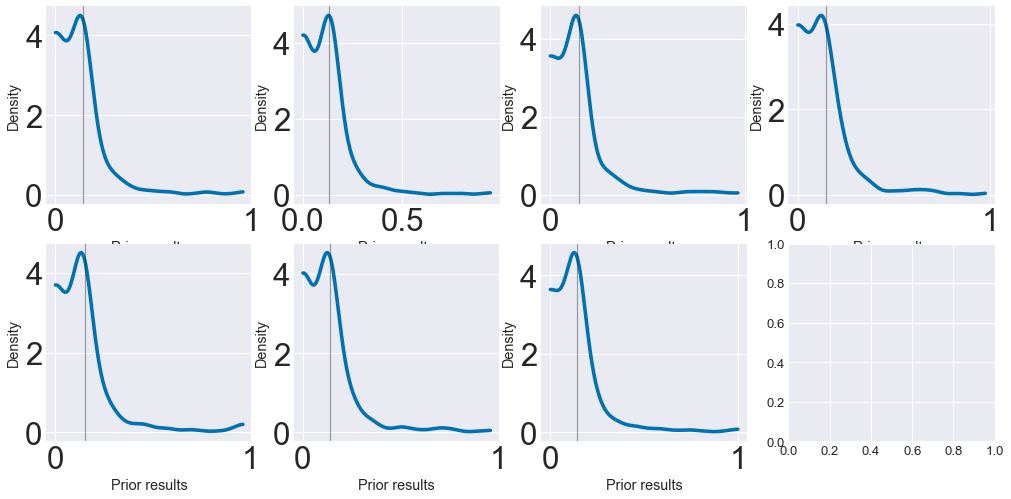

In [20]:
prior_p = softmax(prior_checks["a"][:, None] + prior_checks["a_dpt"], axis=2)[:, 11]
prior_pred_checks(prior_p)

Just to show you, this model indeed takes an eternity to sample, although there are no divergences and the chains look good:

In [21]:
with m_itcpt:
    trace_itcpt = pm.sample(1000, tune=3000, cores=2, random_seed=RANDOM_SEED)

az.summary(trace_itcpt, round_to=2, var_names=["a", "sigma_dpt"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_dpt, sigma_dpt, a]
Sampling 2 chains: 100%|██████████| 8000/8000 [2:14:44<00:00,  1.01s/draws]  


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-2.06,0.04,-2.13,-1.98,0.0,0.0,5970.72,5970.72,6012.83,1386.50,1.0
a[1],-1.33,0.04,-1.41,-1.24,0.0,0.0,6597.45,6597.45,6602.06,1051.85,1.0
a[2],-2.56,0.04,-2.64,-2.48,0.0,0.0,5437.86,5437.86,5470.59,1579.29,1.0
a[3],-1.83,0.04,-1.91,-1.75,0.0,0.0,6314.10,6288.37,6237.22,1409.14,1.0
a[4],-1.30,0.04,-1.37,-1.22,0.0,0.0,6239.16,6239.16,6193.39,1668.37,1.0
a[5],-1.93,0.04,-2.02,-1.85,0.0,0.0,6212.75,6212.75,6211.25,1517.23,1.0
a[6],-1.60,0.04,-1.68,-1.52,0.0,0.0,5603.24,5603.24,5564.70,1305.67,1.0
sigma_dpt,0.25,0.01,0.23,0.26,0.0,0.0,1358.80,1357.17,1356.75,1245.45,1.0


After inquiry, it's neither because of the large amount of data or because of parties spending time near zero that sampling is that long - it's because this model is over-parametrized.

So let's run the efficient varying-intercepts model and compare it to a classical fixed-effects model, to see the amount of shrinkage. These models artificially fix the last category (party "other" here) to zero, so that sampling is dramatically improved (see [here](https://discourse.pymc.io/t/slowness-in-multinomial-softmax-regression/3909) and Osvaldo's BAP2 page 164 for reference), even with the whole dataset:

In [5]:
with pm.Model() as m_itc_fix:
    a_dpt = pm.Normal("a_dpt", -1.8, 0.1, shape=(Ndpts, Nparties - 1))
    a_dpt_f = pm.Deterministic(
        "a_dpt_f", tt.horizontal_stack(a_dpt, tt.zeros(shape=(Ndpts, 1)))
    )
    p = tt.nnet.softmax(a_dpt_f[dpt_id])

    R = pm.Multinomial("R", n=N, p=p, observed=R_obs)

    trace_itc_fix = pm.sample(
        1000, tune=2000, cores=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

with pm.Model() as m_itc_var:
    a = pm.Normal("a", -1.8, 0.1, shape=Nparties - 1)
    a_f = pm.Deterministic("a_f", tt.concatenate([a, [0]]))
    sigma_dpt = pm.Exponential("sigma_dpt", 1.0)

    a_dpt = pm.Normal("a_dpt", a, sigma_dpt, shape=(Ndpts, Nparties - 1))
    a_dpt_f = pm.Deterministic(
        "a_dpt_f", tt.horizontal_stack(a_dpt, tt.zeros(shape=(Ndpts, 1)))
    )
    p = tt.nnet.softmax(a_dpt_f[dpt_id])

    R = pm.Multinomial("R", n=N, p=p, observed=R_obs)

    trace_itc_var = pm.sample(
        1000, tune=2000, cores=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

post_itc_fix = pm.trace_to_dataframe(trace_itc_fix)
post_itc_var = pm.trace_to_dataframe(trace_itc_var)

idata_itc_fix = az.from_pymc3(trace_itc_fix)
idata_itc_var = az.from_pymc3(trace_itc_var)

az.summary(trace_itc_var, round_to=2, var_names=["a", "sigma_dpt"])

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_dpt]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [13:08<00:00,  7.61draws/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_dpt, sigma_dpt, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [06:10<00:00, 16.19draws/s] 


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.69,0.04,-0.77,-0.61,0.0,0.0,2767.56,2758.75,2742.50,1630.06,1.0
a[1],-0.03,0.05,-0.12,0.05,0.0,0.0,2429.19,1714.85,2423.89,1757.83,1.0
a[2],-1.14,0.04,-1.21,-1.06,0.0,0.0,2570.25,2568.12,2571.61,1496.53,1.0
a[3],-0.48,0.04,-0.56,-0.40,0.0,0.0,2264.11,2242.99,2271.37,1575.74,1.0
a[4],-0.01,0.05,-0.09,0.08,0.0,0.0,2548.39,1222.45,2544.85,1806.36,1.0
a[5],-0.58,0.04,-0.66,-0.50,0.0,0.0,2830.97,2789.56,2845.96,1657.19,1.0
sigma_dpt,0.42,0.02,0.38,0.45,0.0,0.0,1913.47,1892.08,1950.57,1667.47,1.0


In [6]:
az.compare({"fixed": trace_itc_fix, "var": trace_itc_var})

/anaconda/envs/fund/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
fixed,0,4.45079e+06,208881,0,0.566077,61971.7,0,True,deviance
var,1,4.45126e+06,211346,463.927,0.433923,62172.5,3205.19,True,deviance


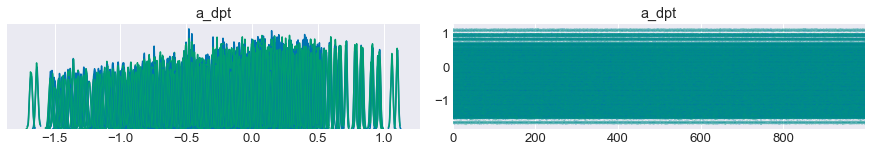

In [8]:
az.plot_trace(trace_itc_fix, var_names=["a_dpt"], compact=True)

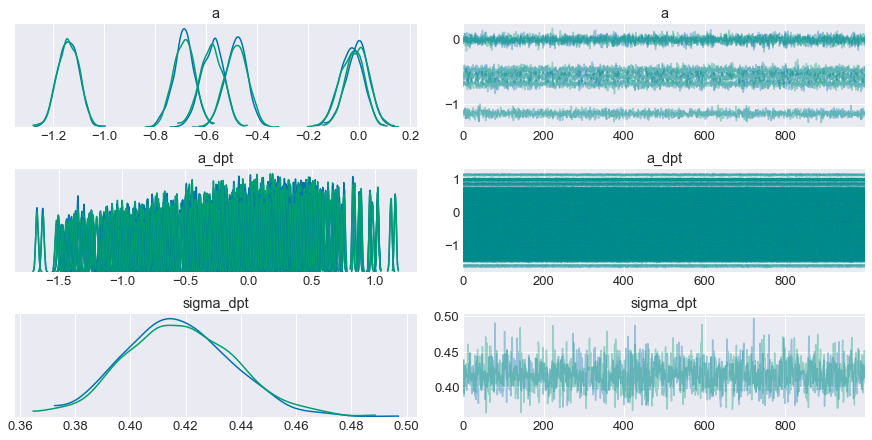

In [9]:
az.plot_trace(trace_itc_var, var_names=["a", "a_dpt", "sigma_dpt"], compact=True)

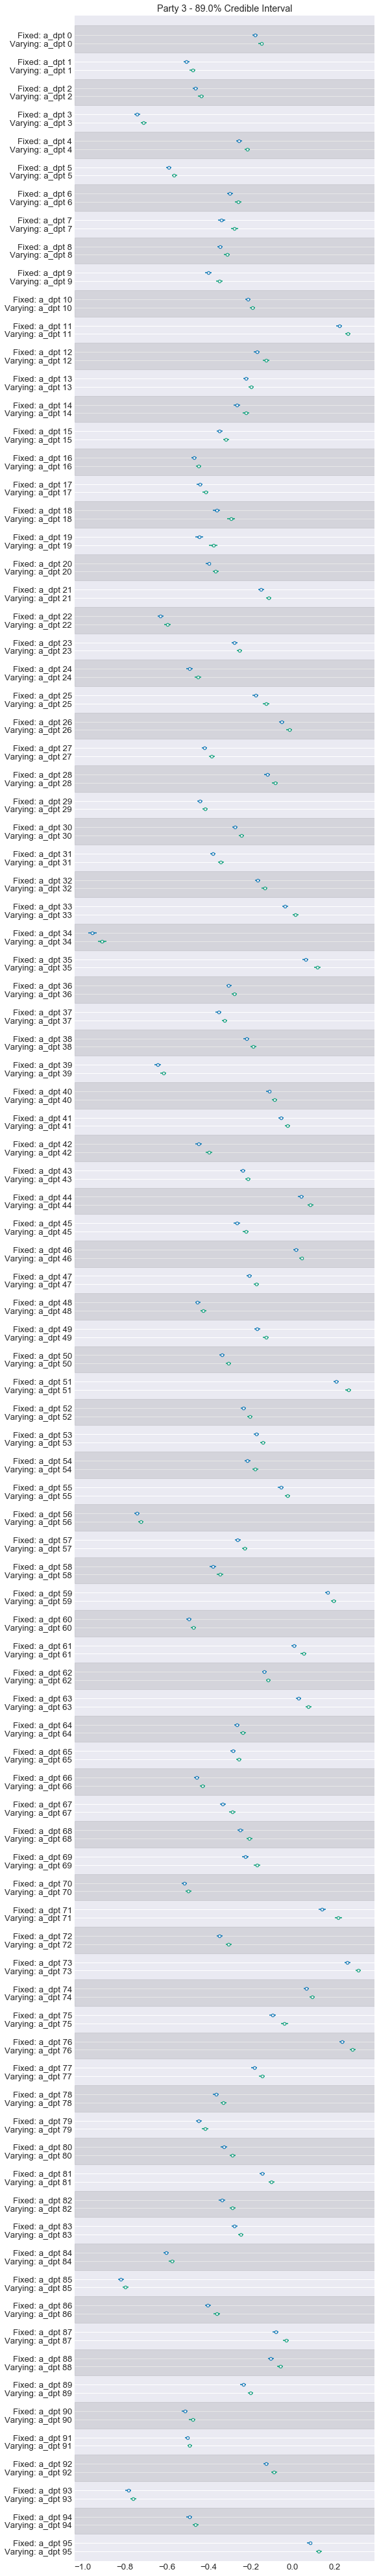

In [25]:
party = 3  # select only one party for simplicity
fig, axes = az.plot_forest(
    [
        idata_itc_fix.posterior.sel({"a_dpt_dim_1": party}),
        idata_itc_var.posterior.sel({"a_dpt_dim_1": party}),
    ],
    model_names=["Fixed", "Varying"],
    var_names=["a_dpt"],
    credible_interval=0.89,
    combined=True,
    figsize=(8, 55),
)
axes[0].set_title(f"Party {party} - 89.0% Credible Interval")
axes[0].grid()

There does not seem to be a lot of shrinkage in the varying-intercepts model, compared to the fixed-effects model - after all, we've got a lot of data in each cluster here. Let's explore that in more detail:

In [26]:
p_mean_fixed = mean_by_cluster(softmax, post_itc_fix)
p_mean_varying = mean_by_cluster(softmax, post_itc_var)
p_mean_varying

Party,0,1,2,3,4,5,6
Department,,,,,,,
0,0.074368,0.158714,0.065032,0.149716,0.238397,0.139898,0.173875
1,0.118805,0.223032,0.040771,0.104246,0.183713,0.161634,0.167798
2,0.187715,0.195967,0.044684,0.118456,0.176430,0.093543,0.183204
3,0.121501,0.204258,0.064703,0.090873,0.220283,0.113290,0.185092
4,0.081657,0.135835,0.067324,0.111107,0.280835,0.185278,0.137963
...,...,...,...,...,...,...,...
91,0.055906,0.181771,0.053423,0.173625,0.177850,0.073776,0.283649
92,0.102975,0.239032,0.067148,0.143436,0.207876,0.082734,0.156798
93,0.072579,0.210276,0.050527,0.095661,0.227873,0.138589,0.204496


In [27]:
a_mean_fixed = mean_by_cluster(identity, post_itc_fix)
a_mean_varying = mean_by_cluster(identity, post_itc_var)
a_mean_varying

Party,0,1,2,3,4,5,6
Department,,,,,,,
0,-0.849310,-0.091234,-0.983464,-0.149595,0.315599,-0.217423,0.0
1,-0.345277,0.284550,-1.414787,-0.476006,0.090612,-0.037427,0.0
2,0.024325,0.067345,-1.410987,-0.436061,-0.037675,-0.672175,0.0
3,-0.420932,0.098531,-1.051049,-0.711385,0.174062,-0.490899,0.0
4,-0.524452,-0.015540,-0.717467,-0.216487,0.710783,0.294870,0.0
...,...,...,...,...,...,...,...
91,-1.624059,-0.444992,-1.669501,-0.490836,-0.466796,-1.346698,0.0
92,-0.420475,0.421639,-0.848056,-0.089068,0.281980,-0.639330,0.0
93,-1.035872,0.027875,-1.398037,-0.759736,0.108240,-0.389036,0.0


In [28]:
global_a = post_itc_var.filter(like="a_f").mean().values
global_p = softmax(post_itc_var.filter(like="a_f").mean().values)
global_p

array([0.10132742, 0.19524586, 0.06441201, 0.12437836, 0.20026414,
       0.11305067, 0.20132154])

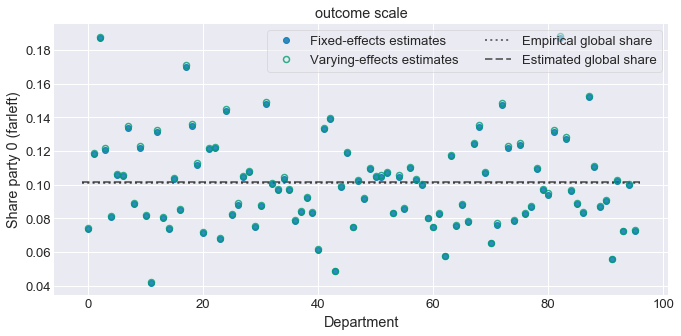

In [29]:
plot_shrinkage(
    0,
    "outcome",
    baseline=global_p,
    mean_clusters_fixed=p_mean_fixed,
    mean_clusters_varying=p_mean_varying,
)

To sum-up, sampling was indeed smooth, without divergence. However, our `mean_by_cluster` and `plot_shrinkage` functions may be biased here. Indeed, I don’t see how to do prior/posterior predictive checks now: artificially setting one of the categories to 0 biases the `p` vector, as the softmax doesn’t know the left-most zero is merely a placeholder - I don’t see a way to tell that to scipy’s softmax function. *So how can I then recover the real `p` vector?*.

That may be why shrinkage seems odd here: the estimated global share doesn't seem to pool the varying-intercepts towards it as it should. Is is because our `p` vector is biased? Or is it because there can't be that much pooling anyway - either because there is so much data, or the sampled population doesn't vary by cluster? Well, let's test that second hypothesis!

In [ ]:
# varier le N selon la pop électorale de chaque département
# zero-inflated multinomial to integrate *all* elections (and not only complete ones)? Tester avec euro2019

In [ ]:
with pm.Model() as hier_model:
    
    sigma_dpt_interp = pm.HalfNormal('sigma_dpt_interp', 10.)
    sigma_fixed = pm.HalfNormal('sigma_fixed', 10.)
    sigma_random = pm.HalfNormal('sigma_random', 10.)
    
    dpt_interp = pm.Normal('dpt_interp', 0., sigma_dpt_interp, shape=(n_dptmts, n_parties-1))
    print('dpt_interp: ', dpt_interp.tag.test_value.shape)
    
    fixed_effect = pm.Normal('fixed_effect', 0., sigma_fixed, shape=(n_regressors-1, n_parties-1))
    print('fixed_effect: ', fixed_effect.tag.test_value.shape)
    
    random_effect = pm.Normal('random_effect', 0., sigma_random, shape=n_parties-1)
    print('random_effect: ', random_effect.tag.test_value.shape)
    
    results_est = dpt_interp[dptmts_idx]\ # intercept: one for each dpt and each party
                    + tt.dot(groupX, fixed_effect)[date_idx]\ # effet fixe sur l'ensemble du pays des prédicteurs nationaux
                    + X_full['chomage'].values[:, None] * random_effect # effet varié du chômage sur chacun des dpts
    results_est = tt.concatenate(tensor_list=[results_est, 
                                              tt.zeros((X_full.shape[0], 1))], 
                                 axis=1)
    print('results_est: ', results_est.tag.test_value.shape)
    
    probs = pm.Deterministic('probs', tt.nnet.softmax(results_est))
    print('probs: ', probs.tag.test_value.shape)
    likelihood = pm.Multinomial('likelihood',
                                n=y_full.sum(axis=1),
                                p=probs,
                                observed=y_full.values)
    
    # might need to increase tunning
    trace = pm.sample(1000, tune=2000, cores=4, random_seed=RANDOM_SEED)